In [3]:
import numpy as np
import pmdarima as pm
import math 
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf

Wählen Sie Inputkürzel aus folgender Quelle: https://www.nasdaq.com/market-activity/stocks/screener
Aktienticker:AAPL
[*********************100%***********************]  1 of 1 completed


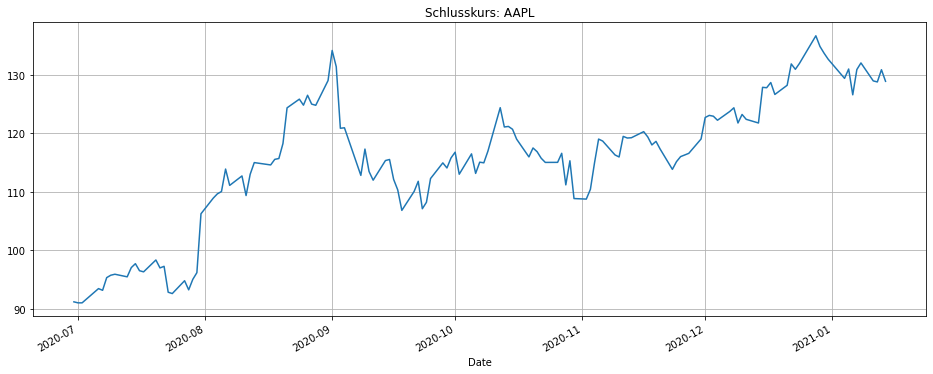

In [4]:
print("Wählen Sie Inputkürzel aus folgender Quelle: https://www.nasdaq.com/market-activity/stocks/screener")
user_input = input("Aktienticker:")
#user_input_startdate = str(input("Startdatum:"))
#user_input_enddate = str(input("Enddatum"))

def get_data():
    data = yf.download(user_input, start="2020-07-01", end="2021-01-15")
    df = pd.DataFrame(data) 
    return df

# Daten laden 
df_loaded = get_data()
# plotten
plot = df_loaded["Close"].plot(figsize=(16,6), title = "Schlusskurs: " + user_input , fontsize =10, grid = True)

In [5]:
df = df_loaded[["Close"]].copy()

# Prüfen auf Staionarität

## Abziehen der zukünftigen Werte von den derzeitigen Werten, wenn nötig öfter bis die Serie staionär ist. Hierzu verwenden wir den ADF - Test. 

In [4]:
fullertest = adfuller(df.Close.dropna()) 
output = pd.Series(fullertest[0:4], index = ["Teststatistik", "P-Wert", "Benutzter Lag", "Zahl der Beobachtungen"])
print(output)

Teststatistik               0.330102
P-Wert                      0.978684
Benutzter Lag               0.000000
Zahl der Beobachtungen    137.000000
dtype: float64


## Die Nullhypothese ist, dass die Serie nicht stationär ist. Wenn der p-Wert kleiner als das Signifikanzniveau (0,05) ist, kann die Nullhypothese noch verworfen werden. 

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

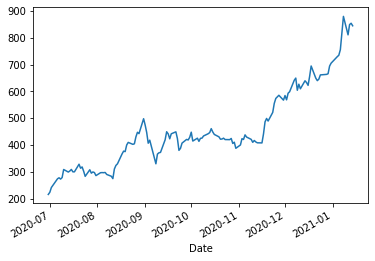

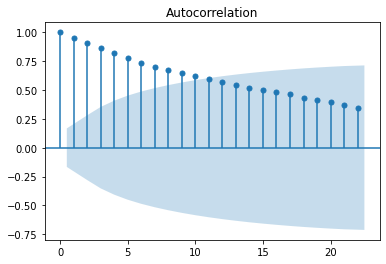

In [5]:
df["Close"].plot()
plt1 = sm.graphics.tsa.plot_acf(df["Close"])
plt1.show 
#plt2 = sm.graphics.tsa.plot_pacf(df["Close"])
#plt2.show

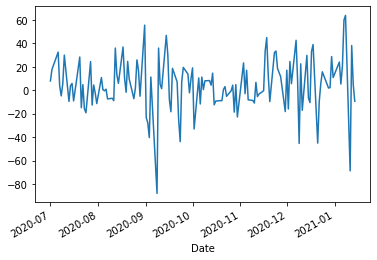

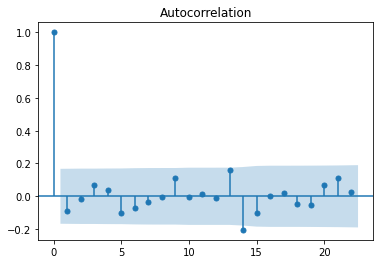

In [6]:
# einmaliges differenzieren (d-Term = +1)
diff = df.Close.diff().dropna()
diff.plot()
plt2 = sm.graphics.tsa.plot_acf(diff)

In [8]:
# returns randomly distribute around the mean of 0 

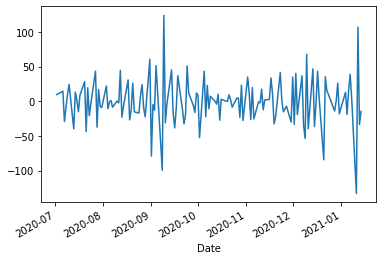

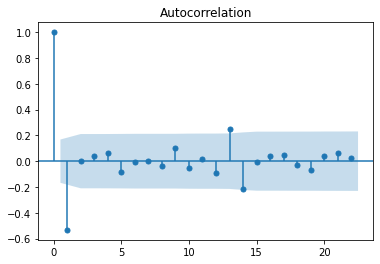

In [7]:
# zweimaliges differenzieren (d-Term = +2)
diff = df.Close.diff().diff().dropna()
diff.plot()
plt3 = sm.graphics.tsa.plot_acf(diff)
# 2nd differencing, the lag goes into the far negative --> Serie überdifferenziert? Ist ein Indikator dafür

# Auch möglich pmdarima zu verwenden, um die Anzahl an Differenzierungen zu erhalten. Prüfen wir dies gegen:

In [8]:
ndiffs(df.Close, test = "adf") # ermitteln der ARIMA Differenzierungsterme (einfacher als manuell)

1

#  Als nächstes ermitteln des p - Terms für den AR (Autoregressiv) Part des Modells 

In [11]:
# hierzu kommt die Partial Autocorrelation function zum Einsatz

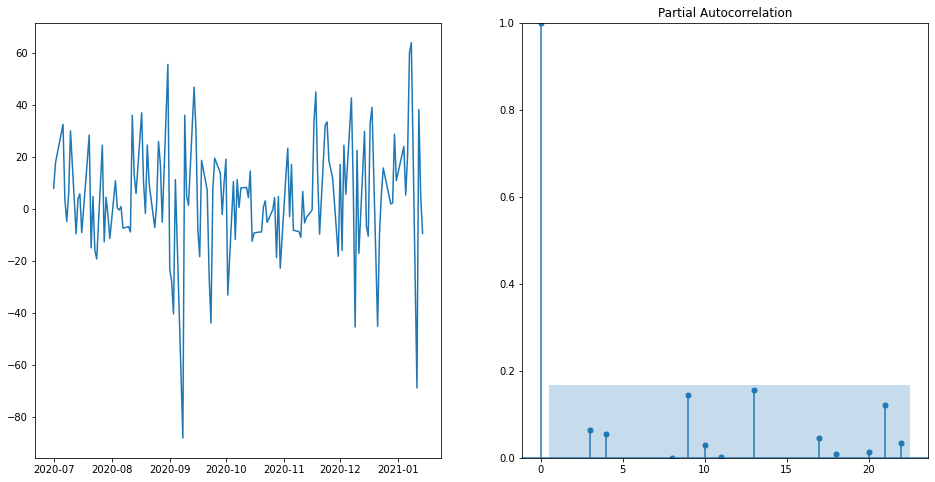

In [9]:
diff_p = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.plot(diff_p)
ax2.set_ylim(0,1)
plot_pacf(diff_p, ax=ax2); # p = 9 (meist höchster Wert ideal)

# q - Wert ermitteln:

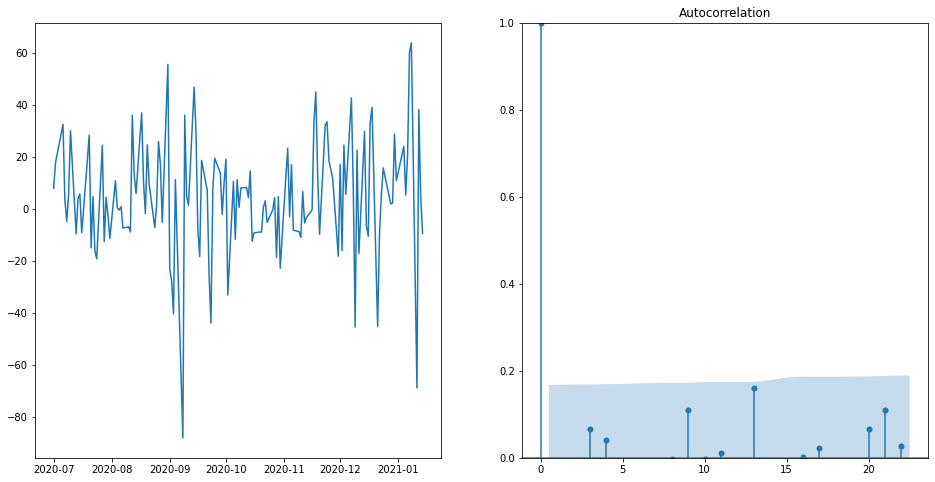

In [10]:
diff_q = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.plot(diff_q)
ax2.set_ylim(0,1)
plot_acf(diff_q, ax=ax2); # q - Wert zB. innerhalb der Grenzen ideal

# Fitting des ARIMA Models

In [11]:
model = ARIMA(df.Close, order=(18,1,5))# order = p,d,q übergeben
result = model.fit()
print(result.summary())

C:\Entwicklung\Python\envs\udemy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Entwicklung\Python\envs\udemy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Entwicklung\Python\envs\udemy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Entwicklung\Python\envs\udemy\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  138
Model:                ARIMA(18, 1, 5)   Log Likelihood                -611.519
Date:                Wed, 20 Jan 2021   AIC                           1271.037
Time:                        17:55:47   BIC                           1341.117
Sample:                             0   HQIC                          1299.516
                                - 138                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2010      1.187      0.169      0.866      -2.125       2.527
ar.L2          0.1307      0.436      0.300      0.764      -0.723       0.985
ar.L3         -0.0290      0.408     -0.071      0.9

# Residuen Fehler

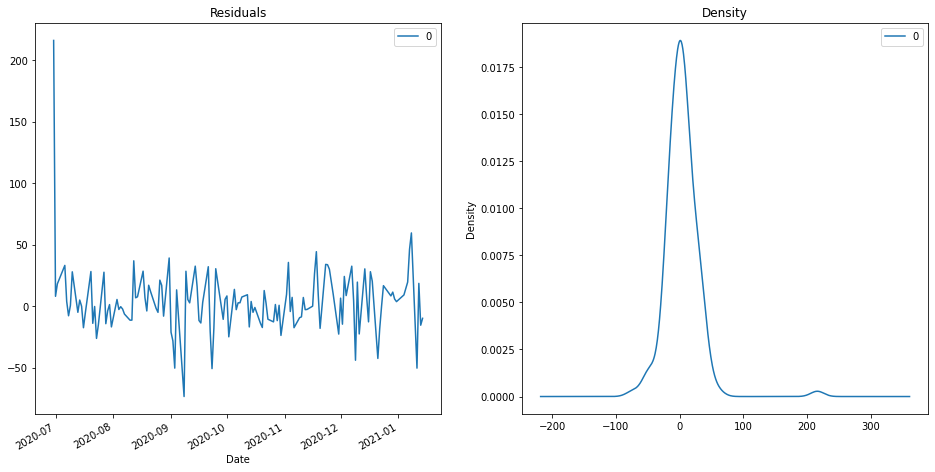

In [12]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2,figsize=(16,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Plot des Forecasts

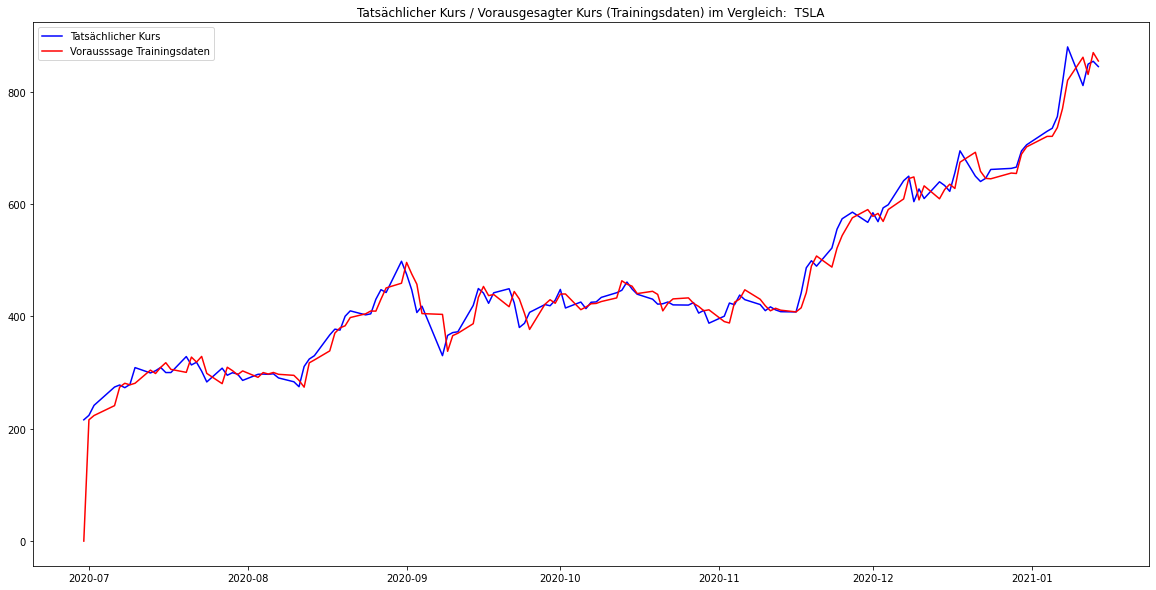

In [13]:
predict = result.predict()
real = df["Close"]
plt.figure(figsize=(20,10))
plt.plot(real, "b",label="Tatsächlicher Kurs")
plt.plot(predict, "r", label="Vorausssage Trainingsdaten")
plt.legend()
plt.title("Tatsächlicher Kurs / Vorausgesagter Kurs (Trainingsdaten) im Vergleich:  " + user_input)
plt.show()

In [14]:
mape = np.mean(np.abs(df.Close - predict)/np.abs(df.Close))
print('MAPE: '+str(mape))

MAPE: 0.042730936785140186


 # Ca. 2,4% MAPE (Mean Absolute Percentage Error) lässt darauf schließen, dass das Model eine geschätzte Genauigkeit von 97,6% erreicht (in Bezug auf Vorhersage des Trainingsdatensatzes!)

# Forecasting

In [15]:
len(df.Close)

138

In [16]:
# split for forecast
train = df.Close[:110]
test = df.Close[110:]

In [17]:
model_forecast = auto_arima(train)
fitted = model_forecast.fit(test)  
# forecast
fc = fitted.predict(n_periods=len(test))
forecast = pd.DataFrame(fc,index = test.index)

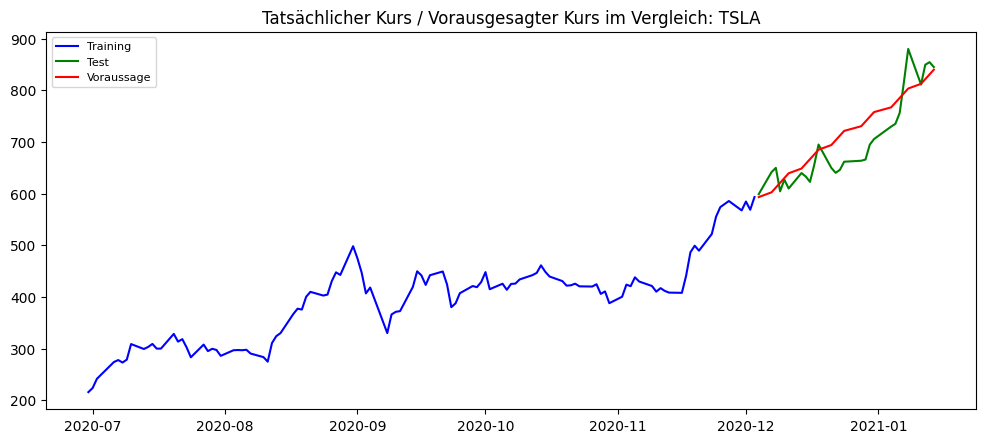

In [63]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train,"b", label="Training")
plt.plot(test,"g", label="Test")
plt.plot(score_new_series,"r", label="Voraussage")
plt.title("Tatsächlicher Kurs / Vorausgesagter Kurs im Vergleich: " + user_input)
plt.legend(loc=2, fontsize=8)
plt.show()

## Wir sehen also, dass anhand des Modells, welches im Training trainiert wird und mit dem Testdatensatz gefitted wird, ein klarer Trend vorausgesagt werden kann, jedoch ist es nicht möglich mit unserem Modell genau den Kurs zu berechnen. 

# Nun verbessern wir den Forecast mit unseren Twitter und Reddit Daten:

In [19]:
forecast_new = forecast.copy()
forecast_new = forecast_new.reset_index()
forecast_new.columns=["Date","Forecast_Price"]
forecast_new

Date  Forecast_Price
0  2020-12-04      854.109630
1  2020-12-07      863.219261
2  2020-12-08      872.328891
3  2020-12-09      881.438522
4  2020-12-10      890.548152
5  2020-12-11      899.657783
6  2020-12-14      908.767413
7  2020-12-15      917.877044
8  2020-12-16      926.986674
9  2020-12-17      936.096304
10 2020-12-18      945.205935
11 2020-12-21      954.315565
12 2020-12-22      963.425196
13 2020-12-23      972.534826
14 2020-12-24      981.644457
15 2020-12-28      990.754087
16 2020-12-29      999.863718
17 2020-12-30     1008.973348
18 2020-12-31     1018.082978
19 2021-01-04     1027.192609
20 2021-01-05     1036.302239
21 2021-01-06     1045.411870
22 2021-01-07     1054.521500
23 2021-01-08     1063.631131
24 2021-01-11     1072.740761
25 2021-01-12     1081.850392
26 2021-01-13     1090.960022
27 2021-01-14     1100.069652

In [20]:
forecast_sentiment = forecast_new.copy()

In [21]:
sentiments = pd.read_csv("Test_CSV.csv",sep=";")
sentiments = sentiments.rename(columns={"_id": "Date"})
sentiments

Date  count   avgNltkPos  avgNltkPNeg  avgNltkPNeu  avgNltkCompound  \
0  2020-12-07       1       0.031       0.0310        0.934           0.8321   
1  2020-12-08       1       0.060       0.0600        0.323           0.9993   
2  2020-12-09       1       0.076       0.0760        0.965           0.9732   
3  2020-12-10       1       0.044       0.0440        0.435           0.9733   
4  2020-12-11       1       0.042       0.0423        0.966           0.9734   
5  2020-12-12       1       0.066       0.0660        0.977           0.9735   

   avgFlairPos  avgFlairNeg  avgFlairTextblobPolarity  \
0        0.666            0                     0.031   
1        0.667            0                     0.060   
2        0.668            0                     0.076   
3        0.669            0                     0.044   
4        0.670            0                     0.042   
5        0.671            0                     0.066   

   avgFlairTextblobSubjectivity  
0                         0.321  
1                         0.322  
2                         0.323  
3                         0.324  
4                         0.325  
5                         0.326

In [22]:
forecast_sentiment["Date"] = forecast_sentiment.Date.astype(str)
sentiments["Date"] = sentiments.Date.astype(str)
#forecast_sentiment["Date"] = pd.to_datetime(forecast_sentiment.Date)
#sentiments["Date"] = pd.to_datetime(sentiments.Date)

In [23]:
join = pd.merge(forecast_sentiment, sentiments, how="outer", on=["Date"])
join.head(7)

Date  Forecast_Price  count   avgNltkPos  avgNltkPNeg  avgNltkPNeu  \
0  2020-12-04      854.109630     NaN         NaN          NaN          NaN   
1  2020-12-07      863.219261     1.0       0.031       0.0310        0.934   
2  2020-12-08      872.328891     1.0       0.060       0.0600        0.323   
3  2020-12-09      881.438522     1.0       0.076       0.0760        0.965   
4  2020-12-10      890.548152     1.0       0.044       0.0440        0.435   
5  2020-12-11      899.657783     1.0       0.042       0.0423        0.966   
6  2020-12-14      908.767413     NaN         NaN          NaN          NaN   

   avgNltkCompound  avgFlairPos  avgFlairNeg  avgFlairTextblobPolarity  \
0              NaN          NaN          NaN                       NaN   
1           0.8321        0.666          0.0                     0.031   
2           0.9993        0.667          0.0                     0.060   
3           0.9732        0.668          0.0                     0.076   
4           0.9733        0.669          0.0                     0.044   
5           0.9734        0.670          0.0                     0.042   
6              NaN          NaN          NaN                       NaN   

   avgFlairTextblobSubjectivity  
0                           NaN  
1                         0.321  
2                         0.322  
3                         0.323  
4                         0.324  
5                         0.325  
6                           NaN

In [24]:
score = join.iloc[:,[0,1,3,4,5,6]]
score.head()

Date  Forecast_Price  avgNltkPos  avgNltkPNeg  avgNltkPNeu  \
0  2020-12-04      854.109630         NaN          NaN          NaN   
1  2020-12-07      863.219261       0.031        0.031        0.934   
2  2020-12-08      872.328891       0.060        0.060        0.323   
3  2020-12-09      881.438522       0.076        0.076        0.965   
4  2020-12-10      890.548152       0.044        0.044        0.435   

   avgNltkCompound  
0              NaN  
1           0.8321  
2           0.9993  
3           0.9732  
4           0.9733

In [25]:
score.shape

(29, 6)

In [26]:
score_new = score.copy()

In [40]:
price_diff = score_new.iloc[0]['Forecast_Price'] - train[-1]


260.7296255606192

In [42]:
diff = 0

for i in range(len(score_new)):
    record = score_new.loc[i]


diff = 0
def calc_sentiment_score(record):
    global diff
    sentiment = record["avgNltkCompound"]

    if sentiment >= 0.6:
        diff += 0.1
        print("Kurs um 0.1 erhöht")
    elif sentiment < 0 :
        diff -= 0.1
        print("Kurs um 0.1 verringert")
    elif sentiment <= 0.5:
        print("Kurs auf gleichem  Niveau")

    return record.Forecast_Price - price_diff + diff

score_new['Price2'] = score_new.apply(calc_sentiment_score, axis = 1)

score_new

Kurs um 0.1 erhöht
Kurs um 0.1 erhöht
Kurs um 0.1 erhöht
Kurs um 0.1 erhöht
Kurs um 0.1 erhöht
Kurs um 0.1 erhöht


Date  Forecast_Price  avgNltkPos  avgNltkPNeg  avgNltkPNeu  \
0   2020-12-04      854.109630         NaN          NaN          NaN   
1   2020-12-07      863.219261       0.031       0.0310        0.934   
2   2020-12-08      872.328891       0.060       0.0600        0.323   
3   2020-12-09      881.438522       0.076       0.0760        0.965   
4   2020-12-10      890.548152       0.044       0.0440        0.435   
5   2020-12-11      899.657783       0.042       0.0423        0.966   
6   2020-12-14      908.767413         NaN          NaN          NaN   
7   2020-12-15      917.877044         NaN          NaN          NaN   
8   2020-12-16      926.986674         NaN          NaN          NaN   
9   2020-12-17      936.096304         NaN          NaN          NaN   
10  2020-12-18      945.205935         NaN          NaN          NaN   
11  2020-12-21      954.315565         NaN          NaN          NaN   
12  2020-12-22      963.425196         NaN          NaN          NaN   
13  2020-12-23      972.534826         NaN          NaN          NaN   
14  2020-12-24      981.644457         NaN          NaN          NaN   
15  2020-12-28      990.754087         NaN          NaN          NaN   
16  2020-12-29      999.863718         NaN          NaN          NaN   
17  2020-12-30     1008.973348         NaN          NaN          NaN   
18  2020-12-31     1018.082978         NaN          NaN          NaN   
19  2021-01-04     1027.192609         NaN          NaN          NaN   
20  2021-01-05     1036.302239         NaN          NaN          NaN   
21  2021-01-06     1045.411870         NaN          NaN          NaN   
22  2021-01-07     1054.521500         NaN          NaN          NaN   
23  2021-01-08     1063.631131         NaN          NaN          NaN   
24  2021-01-11     1072.740761         NaN          NaN          NaN   
25  2021-01-12     1081.850392         NaN          NaN          NaN   
26  2021-01-13     1090.960022         NaN          NaN          NaN   
27  2021-01-14     1100.069652         NaN          NaN          NaN   
28  2020-12-12             NaN       0.066       0.0660        0.977   

    avgNltkCompound      Price2  
0               NaN  593.380005  
1            0.8321  602.589635  
2            0.9993  611.799266  
3            0.9732  621.008896  
4            0.9733  630.218527  
5            0.9734  639.428157  
6               NaN  648.537788  
7               NaN  657.647418  
8               NaN  666.757048  
9               NaN  675.866679  
10              NaN  684.976309  
11              NaN  694.085940  
12              NaN  703.195570  
13              NaN  712.305201  
14              NaN  721.414831  
15              NaN  730.524462  
16              NaN  739.634092  
17              NaN  748.743722  
18              NaN  757.853353  
19              NaN  766.962983  
20              NaN  776.072614  
21              NaN  785.182244  
22              NaN  794.291875  
23              NaN  803.401505  
24              NaN  812.511136  
25              NaN  821.620766  
26              NaN  830.730396  
27              NaN  839.840027  
28           0.9735         NaN

In [28]:
sentiment = 0

if sentiment >= 0.6:
    forecast_sentiment.Forecast_Price[0] += 0.1
    print("Kurs um 0.1 erhöht")
elif sentiment < 0 : 
    forecast_sentiment.Forecast_Price[0] -= 0.1
    print("Kurs um 0.1 verringert")
elif sentiment <= 0.5:
    forecast_sentiment.Forecast_Price[0] += 0
    print("Kurs auf gleichem  Niveau")

print(forecast_sentiment)

Kurs auf gleichem  Niveau
          Date  Forecast_Price
0   2020-12-04      854.109630
1   2020-12-07      863.219261
2   2020-12-08      872.328891
3   2020-12-09      881.438522
4   2020-12-10      890.548152
5   2020-12-11      899.657783
6   2020-12-14      908.767413
7   2020-12-15      917.877044
8   2020-12-16      926.986674
9   2020-12-17      936.096304
10  2020-12-18      945.205935
11  2020-12-21      954.315565
12  2020-12-22      963.425196
13  2020-12-23      972.534826
14  2020-12-24      981.644457
15  2020-12-28      990.754087
16  2020-12-29      999.863718
17  2020-12-30     1008.973348
18  2020-12-31     1018.082978
19  2021-01-04     1027.192609
20  2021-01-05     1036.302239
21  2021-01-06     1045.411870
22  2021-01-07     1054.521500
23  2021-01-08     1063.631131
24  2021-01-11     1072.740761
25  2021-01-12     1081.850392
26  2021-01-13     1090.960022
27  2021-01-14     1100.069652


C:\Entwicklung\Python\envs\udemy\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [47]:
#forecast
score_new_series = score_new[['Date', 'Price2']].set_index('Date')

In [62]:
#score_new_series.index = pd.to_datetime(score_new_series.index)
print(type(score_new_series.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [60]:
print(type(forecast.index))


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
